# Toy Hamiltonian

This example studies a simple Hamiltonian and is to be used as initial test case.

## Settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfe = tf.contrib.eager
import sys
sys.path.append("../")

from IPython import display

In [2]:
from hamiltonians import toy_hamiltonian
from utils import BaseDistributionNormal
from utils import generate_and_save_images

In [3]:
sess = tf.InteractiveSession()

In [4]:
tf.set_random_seed(0)

In [5]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': toy_hamiltonian,  
    'd': 1,               # space dimension
    'num_particles': 1,   # number of particles
    'batch_size': 256,    # Mini batch size 
    'stack_size': 1,      # Size of the stack of bijectors
    'train_iters': int(1e5)}   # Number of training iterations

## Base distribution: Gaussian

In [7]:
base_dist = BaseDistributionNormal(settings)

## Model: Additive coupling / symplectic linear stack

In [14]:
from models import SymplecticAdditiveCoupling, MLP, LinearSymplectic, Chain

In [9]:
bijectors = []
for _ in range(settings['stack_size']):
    bijectors.extend([SymplecticAdditiveCoupling( MLP() ),
                      LinearSymplectic()])
model = Chain(bijectors)

## Define the loss
$\text{KL}( H_{\text{osc}} | H_{\text{toy}} ) \rightarrow \frac{1}{N}\sum_{i=1}^N H_{\text{toy}}( \text{model}(z_i) )$

In [10]:
with tf.name_scope("loss"):
    z_samples = base_dist.sample(settings['batch_size'])    
    loss = tf.reduce_mean( settings['hamiltonian']( model(z_samples) ) )

## Train

In [11]:
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

<Figure size 432x288 with 0 Axes>

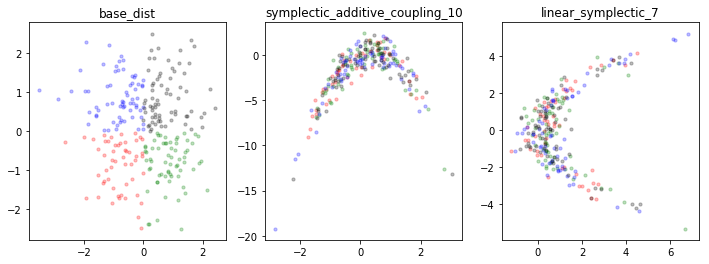

Iteration: 99000, loss = 0.2630228102207184


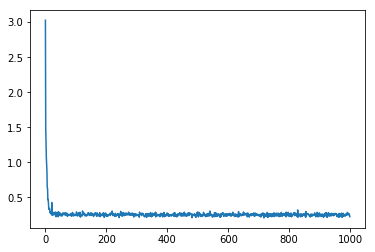

In [51]:
sess.run(tf.global_variables_initializer())

np_losses = []
for i in range(int(settings['train_iters'])):
    _, np_loss = sess.run([train_op, loss])
    if i % 100 == 0:
        np_losses.append(np_loss)
    if i % 1000 == 0:
        display.clear_output(wait=True)
        generate_and_save_images(model,
                                 i + 1,
                                 z_samples,
                                 sess)
        print("Iteration: {}, loss = {}".format(i, np_loss))

start = 0
plt.plot(np_losses[start:])

## Model: HamiltonianFlow 

In [8]:
from models import HamiltonianFlow, MLPHamiltonian

In [14]:
model = HamiltonianFlow( MLPHamiltonian(), initial_t=0., final_t=1., num_steps=100 )

## Define the loss
$\text{KL}( H_{\text{osc}} | H_{\text{toy}} ) \rightarrow \frac{1}{N}\sum_{i=1}^N H_{\text{toy}}( \text{model}(z_i) )$

In [15]:
with tf.name_scope("loss"):
    z_samples = base_dist.sample(settings['batch_size'])  
    loss = tf.reduce_mean( settings['hamiltonian']( model(z_samples) ) )

## Train

In [16]:
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [ ]:
sess.run(tf.global_variables_initializer())

np_losses = []
for i in range(int(settings['train_iters'])):
    _, np_loss = sess.run([train_op, loss])
    if i % 100 == 0:
        np_losses.append(np_loss)
    if i % 1 == 0:
#         display.clear_output(wait=True)
#         generate_and_save_images(model,
#                                  i + 1,
#                                  z_samples,
#                                  sess)
        print("Iteration: {}, loss = {}".format(i, np_loss))

start = 0
plt.plot(np_losses[start:])

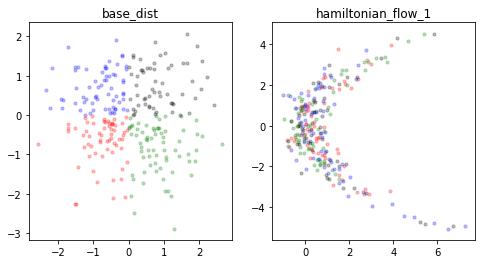

In [18]:
samples = [sess.run(z_samples)]
names = ["base_dist"]
samples.append(sess.run(model(z_samples)))
names.append(model.name)

f, arr = plt.subplots(1, len(samples), figsize=(4 * (len(samples)), 4))
X0 = np.reshape(samples[0], (samples[0].shape[0], 2))
for i in range(len(samples)):
    X1 = np.reshape(samples[i], (samples[0].shape[0], 2))
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='red', alpha=.25)
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] < 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='green', alpha=.25)
    idx = np.logical_and(X0[:, 0] < 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='blue', alpha=.25)
    idx = np.logical_and(X0[:, 0] > 0, X0[:, 1] > 0)
    arr[i].scatter(X1[idx, 0], X1[idx, 1], s=10, color='black', alpha=.25)
    arr[i].set_title(names[i])


## Flow of the system

Position and momentat at time $t$, given initial condition $x_0$:

$$\varphi_t(x_0) = T \circ (\sqrt{2 E} \sin(t + \alpha), \sqrt{2 E} \cos(t + \alpha) ) \, .$$

with

$$  \tan(\alpha) = \frac{q_0}{p_0} \, ,\quad \sqrt{2E} = \frac{q_0}{\sin(\alpha)}\, ,\quad (q_0,p_0) = T^{-1} \circ x_0 \,.$$

# TODO

In [ ]:
# from utils import system_flow
    
# # Initial conditions
# Q_0 = 1.
# P_0 = 0
# ts = np.arange(0,10,.1, dtype=NP_DTYPE)
# points = system_flow(Q_0, P_0, model, ts).numpy()
# qs = points[:,0,0]
# ps = points[:,1,0]
# plt.plot(qs,ps)

Flow is area-preserving. Here show flow of the circle:

In [ ]:
# delta = np.pi/20
# theta = np.arange(0,2*np.pi+delta, delta, dtype=NP_DTYPE)
# circle = np.stack([np.cos(theta), np.sin(theta)], axis=0)
# plt.plot(circle[0], circle[1])

# ts = np.array([1, 5, 10], dtype=NP_DTYPE)
# qs = []
# ps = []
# for i in range(circle.shape[1]):
#     Q = circle[0][i]
#     P = circle[1][i]
#     points = system_flow(Q, P, model, ts).numpy()
#     qs.append(points[:,0,0])
#     ps.append(points[:,1,0])
# plt.plot(qs,ps)

### Compare with numerical solution of Hamilton's equations

In [ ]:
def f(q,p):
    """- d H / d q = - q + \tfrac{1}{4} p ^2"""
    return -q + 1/4 * p**2

def g(q,p):
    """d H / d p = - \tfrac{1}{2} q p + \tfrac{1}{16} p(1 + 2 p^2)"""
    return -1/2 * p * q + 1/16 * p * (1 + 2 * p**2)

In [ ]:
from utils import euler

N = 10000 # Number of time steps
h = 0.01 # size of time step
qsol, psol = euler(Q_0, P_0, f, g, N, h)
# Plot against qs ps from bijector solution
plt.plot(qsol, psol)
plt.plot(qs, ps)

This is quantitatively in agreement with the behavior obtained from the normalizing flow approach. 

TODO: Small discrepancies go away if we use a better integrator like stormer verlet than euler or train for more time?